In [1]:
import os
import numpy as np
import sys
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'

BTK_PATH = '/home/users/sowmyak/BlendingToolKit/'
sys.path.insert(0, BTK_PATH)
import btk
from btk import config
from scipy import spatial

ROOT_DIR = '/home/users/sowmyak/ResidualDetectron'
# Directory to save logs and trained model
MODEL_DIR = '/scratch/users/sowmyak/resid/logs'
# path to images
DATA_PATH = '/scratch/users/sowmyak/resid/data'
CODE_PATH = '/home/users/sowmyak/ResidualDetectron/scripts'
sys.path.append(CODE_PATH)
import btk_utils

MODEL_PATH = None
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils_btk_only as utils
import mrcnn.model_btk_only as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

import scarlet
import scarlet.display
import tensorflow as tf

MODEL_PATH = 'resid_btk_square_group_3_20190213T1020/mask_rcnn_resid_btk_square_group_3__0263.h5'




def get_ax(rows=1, cols=1, size=5):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

/home/users/sowmyak/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class temp_params():
    def __init__(self, model_name='15_8',
                 model_path='resid15_820181115T1229/mask_rcnn_resid15_8_0065.h5'):
        self.model_name = model_name
        self.model_path = "/scratch/users/sowmyak/resid/logs/" + model_path

path = 'resid_btk_square_group_3_20190213T1020/mask_rcnn_resid_btk_square_group_3__0263.h5'
Args = temp_params(model_path="")
Args.model_path=None
mean1 = 1.6361405416087091 
std1 = 416.16687641284665
mean2 = 63.16814480535191 
std2 = 2346.133101333463
MODEL_DIR = '/scratch/users/sowmyak/resid/logs'

count = 4000
catalog_name = os.path.join("/scratch/users/sowmyak/data", 'OneDegSq.fits')
resid_model = btk_utils.Resid_btk_model(Args.model_name, Args.model_path,
                                        MODEL_DIR, training=False,images_per_gpu=1)
resid_model.config.BACKBONE_STRIDES = [8, 16, 32, 64]
resid_model.config.SKIP_P2_RPN = True
resid_model.config.RPN_ANCHOR_SCALES = (8, 16, 32, 64)
resid_model.config.BACKBONE = 'resnet41'
resid_model.make_resid_model(catalog_name, count=count,
                             max_number=2, augmentation=False)

setting seed 199
Setting scarlet_resid_paramsa as meas_params
Loaded 4000 blends
detection minimum confidence score: 0.965


In [3]:
resid_model.config.display()


Configurations:
BACKBONE                       resnet41
BACKBONE_STRIDES               [8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.965
DETECTION_NMS_THRESHOLD        0.2
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128  12]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               10
MEAN_PIXEL   

<IPython.core.display.Javascript object>


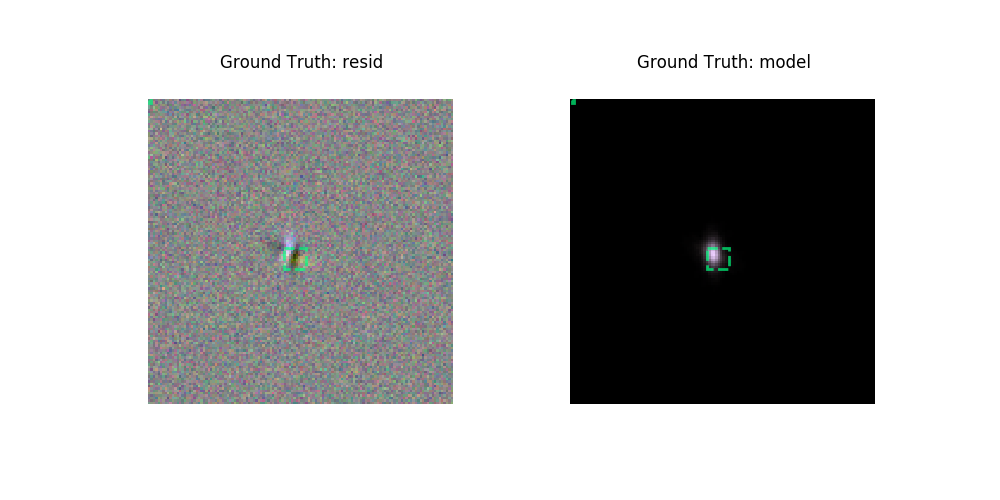

Input Image              shape: (1, 128, 128, 12)     min:   -9.00750  max:   12.61500  float32


<IPython.core.display.Javascript object>


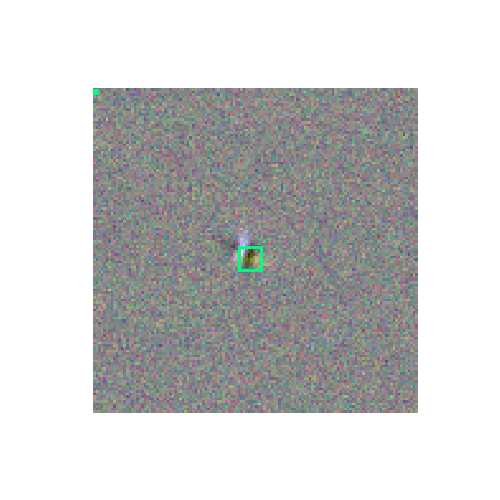


*** No instances to display *** 



In [4]:
image,gt_bbox, gt_class_id = resid_model.dataset.load_input()
ax = get_ax(cols=2)
class_names= ['background', 'resid']
log("Input Image", image)
visualize.display_instances(image[0], gt_bbox[0], gt_class_id[0], 
                            class_names, None, ax=ax[0],
                            title="Ground Truth: resid", colors=['#00FF7F']*2)

#ax = get_ax(1)
flip = np.concatenate((image[0, :,:,6:12], image[0, :,:,0:6]), axis=2)
visualize.display_instances(flip, gt_bbox[0], gt_class_id[0], 
                            class_names, None, ax=ax[1],
                            title="Ground Truth: model", colors=['#00FF7F']*2)
r = resid_model.model.detect(image)[0]
ax = get_ax(rows=1, cols=1)
visualize.display_instances(image[0], r['rois'], r['class_ids'], 
                                class_names, r['scores'], ax=ax,
                                title="Residual", limits=(34, 94))
visualize.draw_boxes(image[0], boxes=gt_bbox[0], refined_boxes=gt_bbox[0], ax=ax, colors=['#00FF7F']*len(gt_bbox[0]))

In [5]:
images = np.array(image, dtype=np.float32)
image_shape = np.array([images[0].shape]*resid_model.config.BATCH_SIZE,
                       dtype=np.int32)
# Anchors
anchors = resid_model.model.get_anchors(image_shape[0][:2])
anchors = np.broadcast_to(anchors,
                          (resid_model.config.BATCH_SIZE,) + anchors.shape)
anchors_denorm = utils.denorm_boxes(anchors, image_shape[0,:2])
backbone_shapes = modellib.compute_backbone_shapes(resid_model.config, image_shape[0])
modellib.log("image", images)
modellib.log("image_shape", image_shape)
modellib.log("anchors", anchors)
modellib.log("model.anchors", resid_model.model.anchors)
modellib.log("denormalized anchors", anchors_denorm)
modellib.log("backbone_shapes", backbone_shapes)


num_levels = len(backbone_shapes)
anchors_per_cell = len(resid_model.config.RPN_ANCHOR_RATIOS)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // resid_model.config.RPN_ANCHOR_STRIDE**2)
print("Count: ", anchors.shape[1])
print("Scales: ", resid_model.config.RPN_ANCHOR_SCALES)
print("ratios: ", resid_model.config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
print("Anchors per level: ", anchors_per_level)

image                    shape: (1, 128, 128, 12)     min:   -9.00750  max:   12.61500  float32
image_shape              shape: (1, 3)                min:   12.00000  max:  128.00000  int32
anchors                  shape: (1, 340, 4)           min:    0.00000  max:    1.00000  float32
model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64
denormalized anchors     shape: (1, 340, 4)           min:    0.00000  max:  128.00000  float64
backbone_shapes          shape: (4, 2)                min:    2.00000  max:   16.00000  int64
Count:  340
Scales:  (8, 16, 32, 64)
ratios:  [1]
Anchors per Cell:  1
Levels:  4
Anchors per level:  [256, 64, 16, 4]


<IPython.core.display.Javascript object>


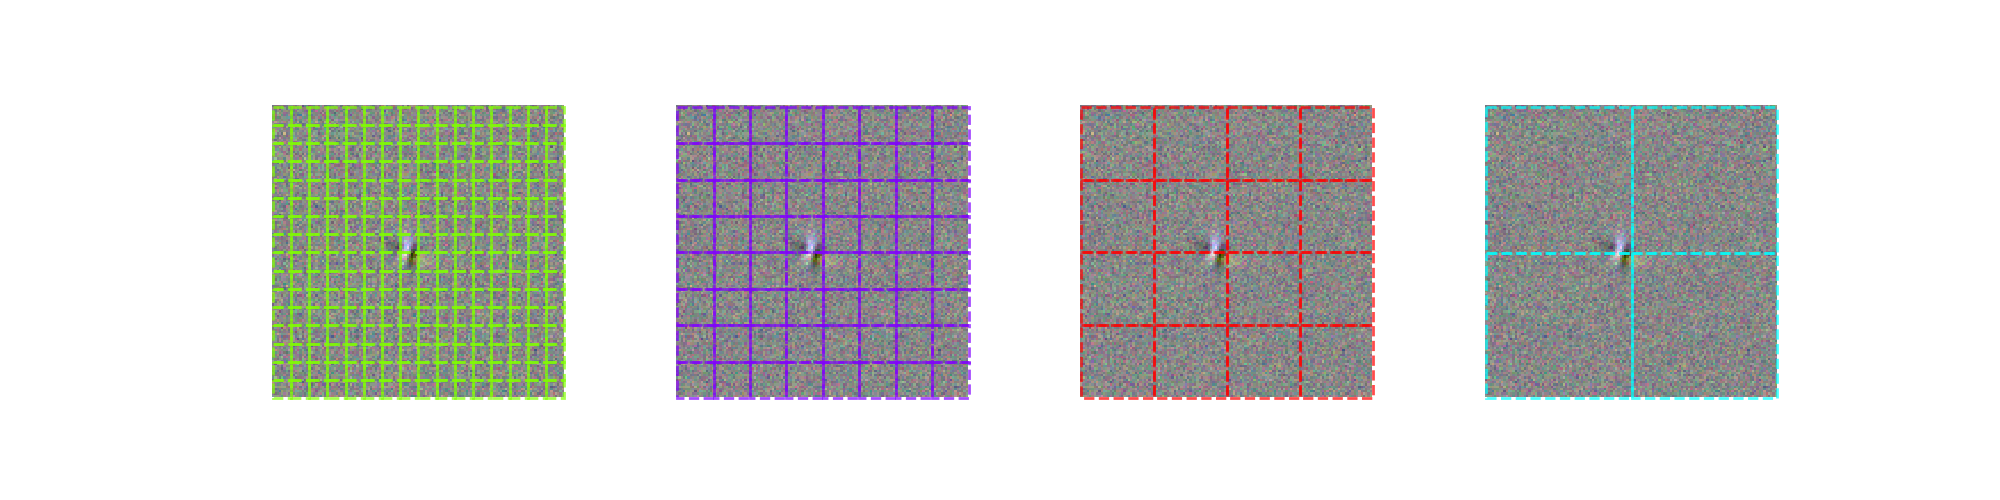

In [6]:
start_idx = 0 
ax=get_ax(rows=1, cols=num_levels)
colors = visualize.random_colors(num_levels)
end_indices =[ ]
for i in range(num_levels):
    end_idx = start_idx + anchors_per_level[i]
    anchors_l = anchors_denorm[0, start_idx:end_idx]
    visualize.display_instances(image[0], anchors_l, np.ones(len(anchors_l), dtype=int), 
                                class_names, None, ax=ax[i], colors=[colors[i]]*len(anchors_l))
    start_idx = end_idx 
    end_indices.append(start_idx)
     

<IPython.core.display.Javascript object>


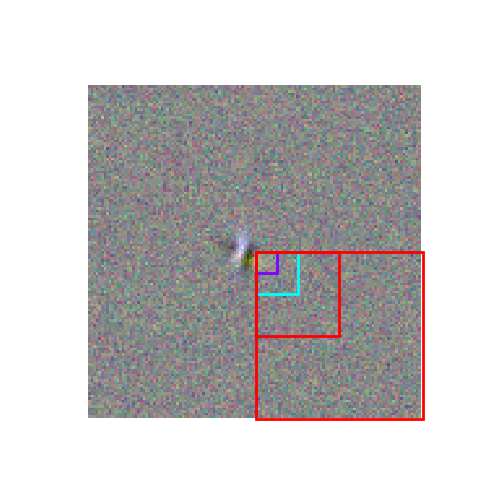


*** No instances to display *** 

Level 0. Anchors:    256  Feature map Shape: [16 16]
Level 1. Anchors:     64  Feature map Shape: [8 8]
Level 2. Anchors:     16  Feature map Shape: [4 4]
Level 3. Anchors:      4  Feature map Shape: [2 2]


In [7]:
ax=get_ax(rows=1, cols=1)
visualize.display_instances(image[0], np.empty(0),None, 
                            class_names, None, ax=ax)
levels = len(backbone_shapes)
for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors_denorm[0, level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / resid_model.config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / resid_model.config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)
plt.show()

In [8]:
activations2 = resid_model.model.run_graph(image, [
    ("rpn_bbox",           resid_model.model.keras_model.get_layer("rpn_bbox").output),
    ("rpn_class",          resid_model.model.keras_model.get_layer("rpn_class").output),
    ("roi",                resid_model.model.keras_model.get_layer("ROI").output),
])

rpn_bbox                 shape: (1, 340, 3)           min:   -0.99840  max:    0.78387  float32
rpn_class                shape: (1, 340, 2)           min:    0.28069  max:    0.71931  float32
roi                      shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32


<IPython.core.display.Javascript object>


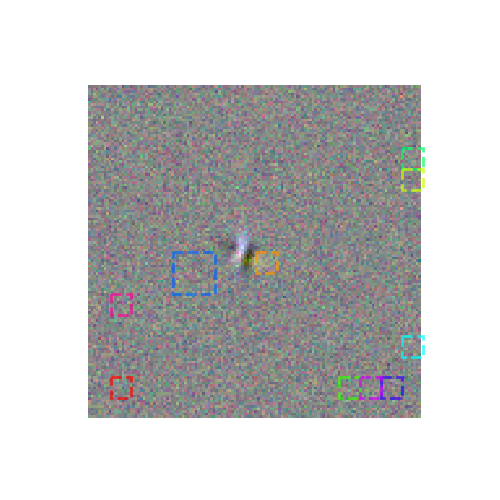

In [9]:
num=10
ax=get_ax(rows=1)
colors = visualize.random_colors(num)
anchors_l = anchors_denorm[0][np.argsort(activations2['rpn_class'][:,:,1].flatten())[::-1]][:num]
visualize.display_instances(image[0], anchors_l, np.ones(len(anchors_l), dtype=int), 
                            class_names, None, ax=ax, colors=colors)


In [10]:
# Run RPN sub-graph
pillar = resid_model.model.keras_model.get_layer("ROI").output  # node to start searching from
# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = resid_model.model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = resid_model.model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = resid_model.model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = resid_model.model.run_graph(image, [
    ("rpn_class", resid_model.model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", resid_model.model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", resid_model.model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", resid_model.model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", resid_model.model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 340, 2)           min:    0.28069  max:    0.71931  float32
pre_nms_anchors          shape: (1, 340, 4)           min:    0.00000  max:    1.00000  float32
refined_anchors          shape: (1, 340, 4)           min:   -0.00885  max:    1.00495  float32
refined_anchors_clipped  shape: (1, 340, 4)           min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (100,)                min:    0.00000  max:   99.00000  int32
proposals                shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32


Showing top 10 anchors before refinement


<IPython.core.display.Javascript object>


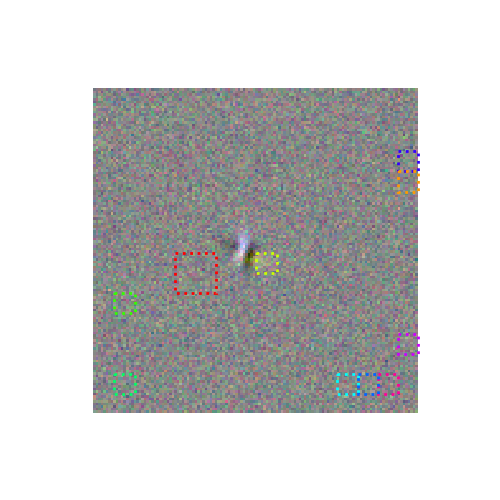

In [11]:
# Show top anchors by score (before refinement)
limit = 10

print(f"Showing top {limit} anchors before refinement")
ax=get_ax()
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image[0], boxes=resid_model.model.anchors[sorted_anchor_ids[:limit]], ax=ax)


In [12]:
modellib.log("model.anchors", resid_model.model.anchors)

model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64


<IPython.core.display.Javascript object>


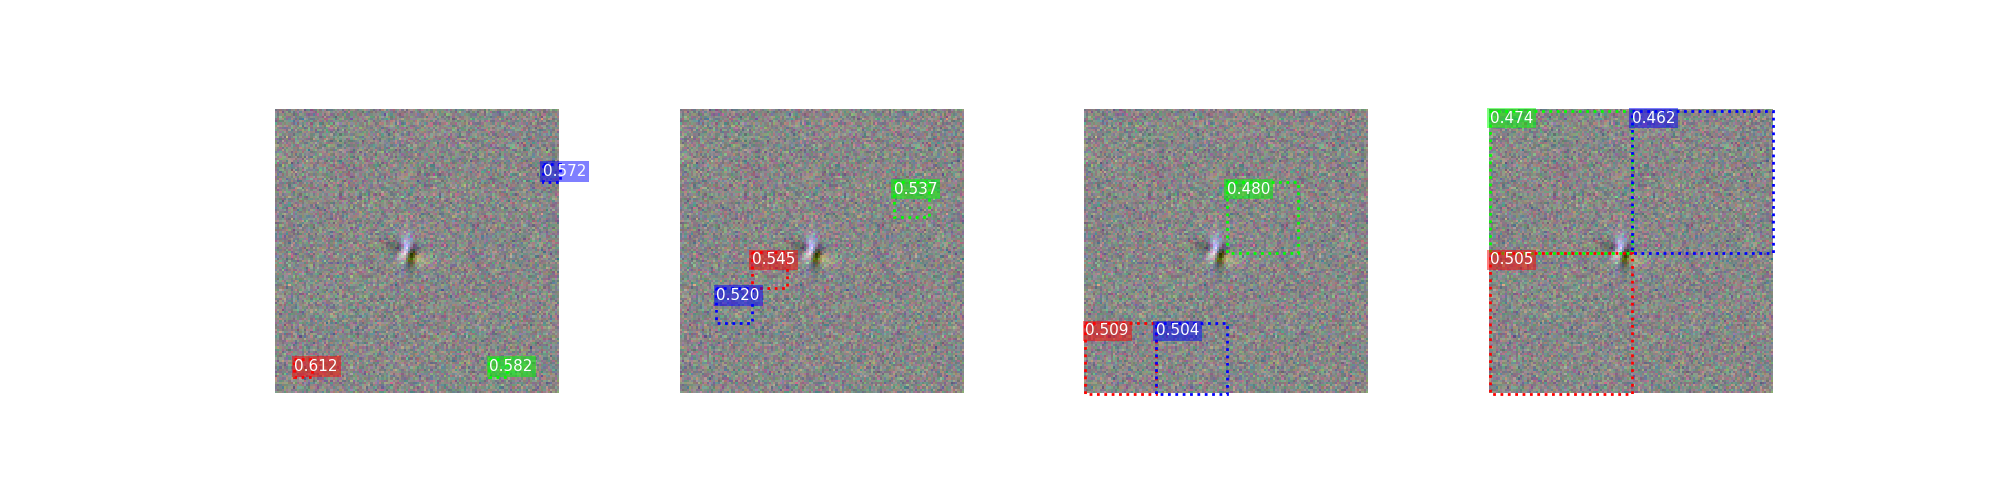

In [13]:
limits = [3]*len(end_indices)
start=0
ax=get_ax(cols=len(end_indices))
for i , e in enumerate(end_indices):
    scores_level = rpn['rpn_class'][:,:,1].flatten()[start:e]
    sorted_anchor_ids = np.argsort(scores_level)[::-1]
    anchors_level = resid_model.model.anchors[start:e]
    sel_scores_level =scores_level[sorted_anchor_ids[:limits[i]]]
    captions = ["{:.3f}".format(s) for s in sel_scores_level]
    visualize.draw_boxes(image[0], boxes=anchors_level[sorted_anchor_ids[:limits[i]]],
                         captions=captions, ax=ax[i])
    start=e

Showing top 10 anchors after refinement


<IPython.core.display.Javascript object>


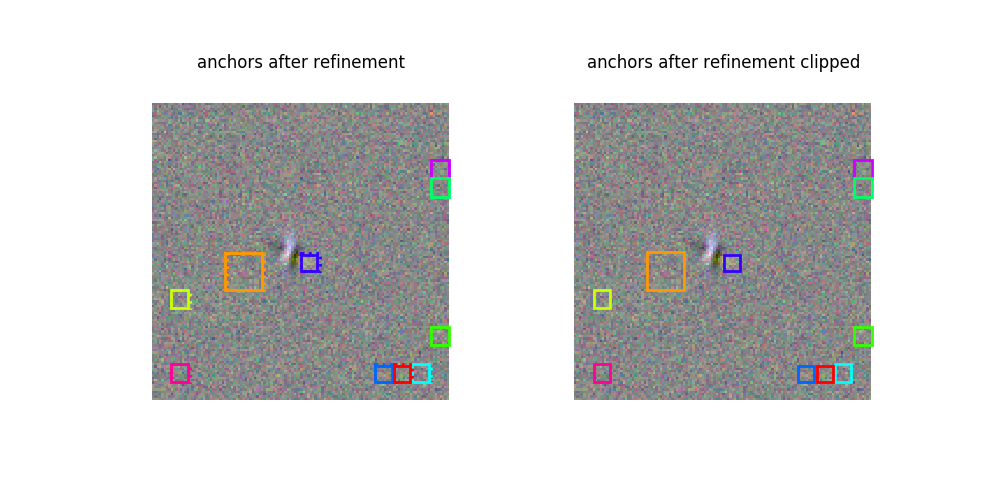

In [18]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 10

print(f"Showing top {limit} anchors after refinement")


pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image[0].shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image[0].shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image[0].shape[:2])
colors = visualize.random_colors(len(refined_anchors_clipped[:limit]))
ax = get_ax(1, 2)
visualize.draw_boxes(image[0], boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit],
                     ax=ax[0], colors=colors, title='anchors after refinement')
# visualize.draw_boxes(image, boxes=gt_bbox, refined_boxes=gt_bbox, ax=ax[0], colors=['#00FF7F'])
visualize.draw_boxes(image[0], refined_boxes=refined_anchors_clipped[:limit], ax=ax[1], colors=colors,
                     title='anchors after refinement clipped')

In [14]:
modellib.log("model.anchors", resid_model.model.anchors)

model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64


target_rpn_match         shape: (340,)                min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 3)              min:  -10.39721  max:    1.87500  float64
positive_anchors         shape: (2, 4)                min:    0.00000  max:   72.00000  float64
negative_anchors         shape: (254, 4)              min:    0.00000  max:  128.00000  float64
neutral anchors          shape: (84, 4)               min:    0.00000  max:  128.00000  float64
refined_anchors          shape: (2, 4)                min:    0.00000  max:   71.00000  float32


<IPython.core.display.Javascript object>


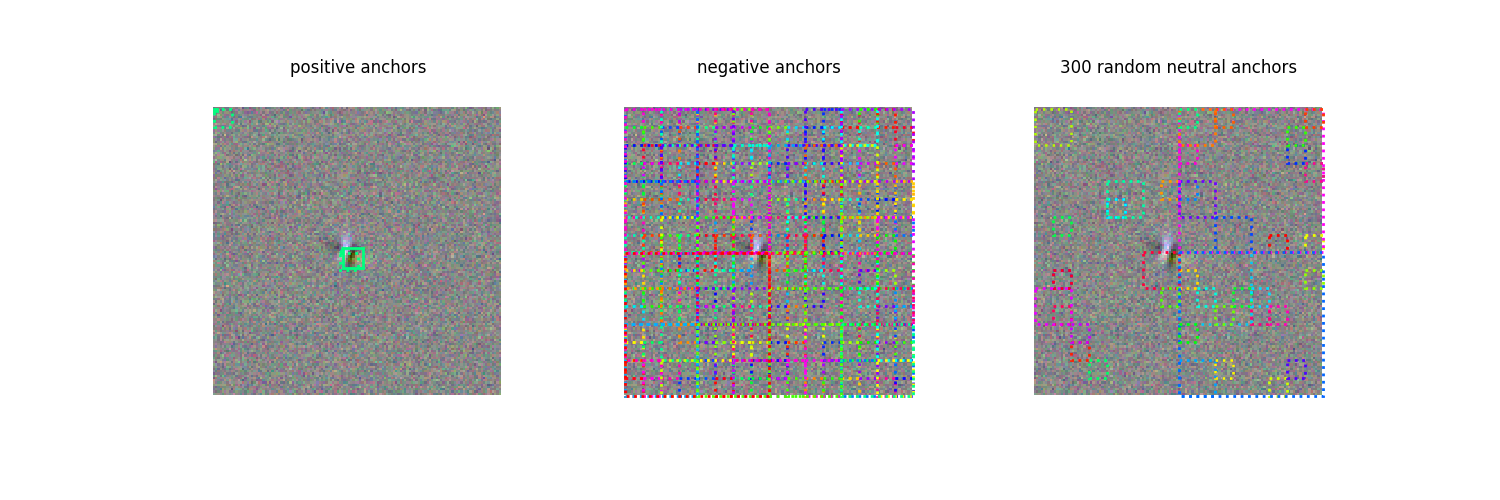

In [19]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image[0].shape, resid_model.model.anchors, gt_class_id[0], gt_bbox[0], resid_model.model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = resid_model.model.anchors[positive_anchor_ix]
negative_anchors = resid_model.model.anchors[negative_anchor_ix]
neutral_anchors = resid_model.model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * resid_model.model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

#visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax(), colors=['#00FF7F'])

ax=get_ax(cols=3)
        
# Show positive anchors
visualize.draw_boxes(image[0], boxes=positive_anchors, 
                     refined_boxes=refined_anchors, ax=ax[0], title='positive anchors',colors=['#00FF7F']*2)

# Show negative anchors
visualize.draw_boxes(image[0], boxes=negative_anchors, ax=ax[1], title='negative anchors')


# Show neutral anchors. They don't contribute to training.
pick = np.random.choice(range(len(neutral_anchors)), 50)
visualize.draw_boxes(image[0], boxes=neutral_anchors[pick], ax=ax[2], title='300 random neutral anchors')

In [16]:
modellib.log("model.anchors", resid_model.model.anchors)



model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64


Showing top 10 of 100 anchors after NMS with threshold of 0.7


<IPython.core.display.Javascript object>


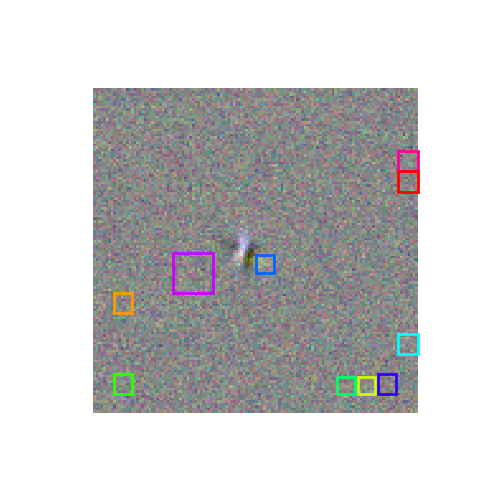

In [20]:
# Show refined anchors after non-max suppression
limit = 10
print(f"Showing top {limit} of {len(rpn['post_nms_anchor_ix'])} anchors after NMS with threshold of {resid_model.model.config.RPN_NMS_THRESHOLD}")
ax=get_ax()
ixs = rpn["post_nms_anchor_ix"][:limit]

visualize.draw_boxes(image[0], refined_boxes=refined_anchors_clipped[ixs], ax=ax)
#visualize.draw_boxes(image[0], boxes=gt_bbox[0], refined_boxes=gt_bbox[0], ax=ax, colors=['#00FF7F']*2)

proposals                shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 100, 2)           min:    0.24779  max:    0.75221  float32
deltas                   shape: (1, 100, 2, 3)        min:   -0.80344  max:    0.85217  float32
detections               shape: (1, 10, 6)            min:    0.00000  max:    0.00000  float32
100 Valid proposals out of 100
1 Positive ROIs
[('background', 99), ('resid', 1)]


<IPython.core.display.Javascript object>


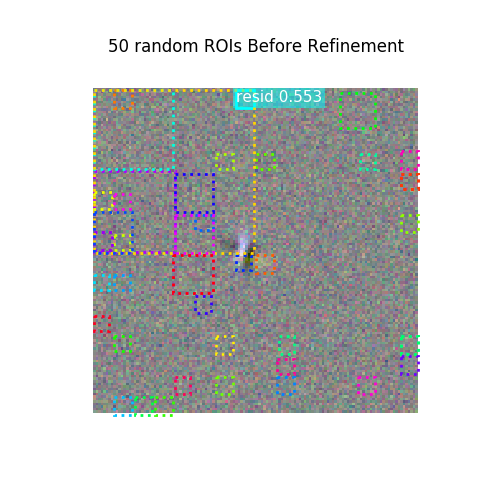

In [21]:
# Get input and output to classifier and mask heads.
mrcnn = resid_model.model.run_graph(image, [
    ("proposals", resid_model.model.keras_model.get_layer("ROI").output),
    ("probs", resid_model.model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", resid_model.model.keras_model.get_layer("mrcnn_bbox").output),
    ("detections", resid_model.model.keras_model.get_layer("mrcnn_detection").output),
])


# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = resid_model.model.config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 50
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image[0], boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title=f"{limit} random ROIs Before Refinement",
                     ax=get_ax())

In [22]:
modellib.log("model.anchors", resid_model.model.anchors)

model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64


roi_bbox_specific        shape: (100, 3)              min:   -0.80344  max:    0.62601  float32
refined_proposals        shape: (100, 4)              min:   -5.00000  max:  130.00000  int32


<IPython.core.display.Javascript object>


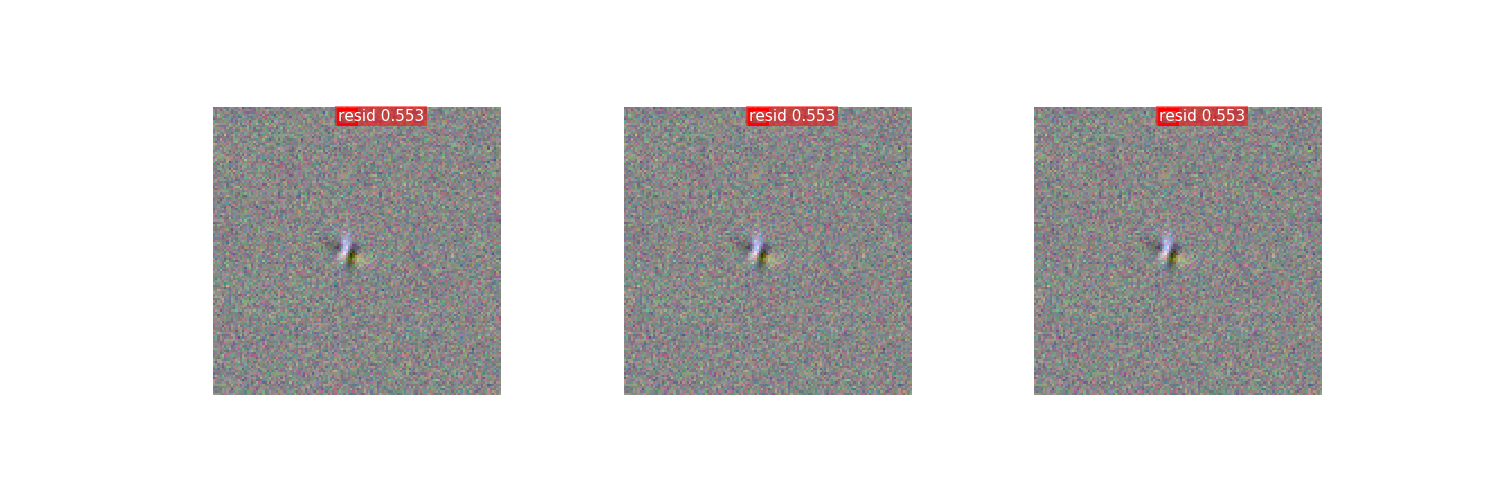

0
1
2


In [23]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * resid_model.model.config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 3

ids = np.random.randint(0, len(roi_positive_ixs), limit+1)  # Display random sample
ax=get_ax(cols=limit)
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
for i in range(limit):
    print(i)
    visualize.draw_boxes(image[0], boxes=proposals[roi_positive_ixs][ids[i:i+1]],
                         refined_boxes=refined_proposals[roi_positive_ixs][ids[i:i+1]],
                         visibilities=np.where(roi_class_ids[roi_positive_ixs][ids[i:i+1]] > 0, 1, 0),
                         ax=ax[i],captions=captions[i:i+1])

In [24]:
modellib.log("model.anchors", resid_model.model.anchors)

model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64


 Only positive: Keep 1 detections:
[69]
Remove boxes below 0.965 confidence. Keep 0:
[]


<IPython.core.display.Javascript object>


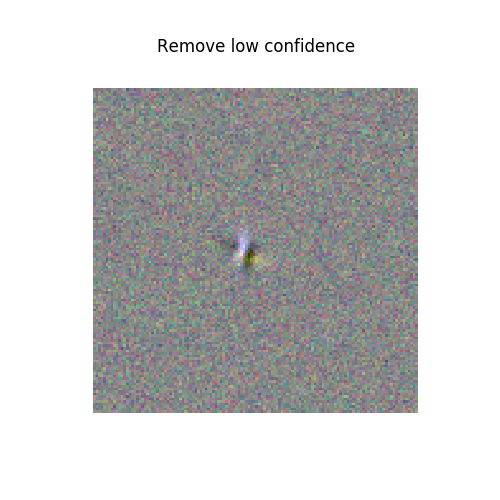

In [25]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print(" Only positive: Keep {} detections:\n{}".format(keep.shape[0], keep))


# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= resid_model.model.config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    resid_model.model.config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image[0], boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Remove low confidence",
    ax=get_ax())

In [25]:
modellib.log("model.anchors", resid_model.model.anchors)

model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64



Kept after per-class NMS with threshold 0.2 : 0
[]


<IPython.core.display.Javascript object>


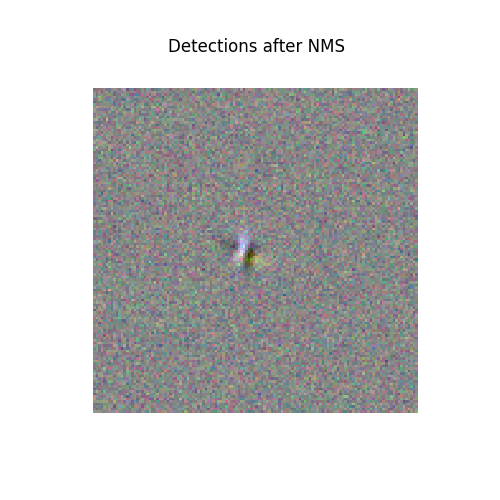

In [26]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            resid_model.model.config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS with threshold {} : {}\n{}".format(resid_model.model.config.DETECTION_NMS_THRESHOLD, keep.shape[0], keep))


# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image[0], boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

In [27]:
modellib.log("model.anchors", resid_model.model.anchors)

model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64


<IPython.core.display.Javascript object>


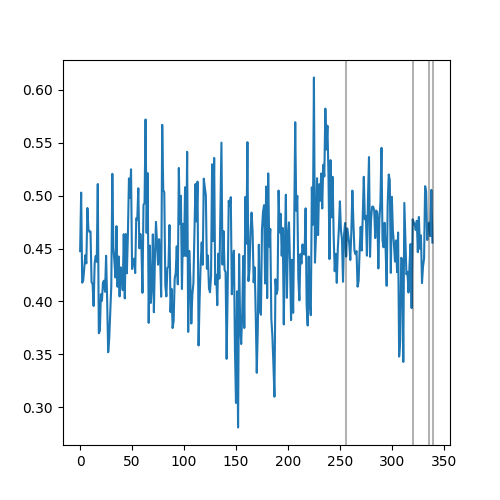

In [27]:
ax=get_ax()
ax.plot(activations2['rpn_class'][0].T[1])
for e in end_indices:
    ax.axvline(e, color='k', alpha=0.3)

In [36]:
visualize.display_weight_stats(resid_model.model)

In [50]:
layers = resid_model.model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in ['BatchNorm'], 
                layers))

In [55]:
layers[0].__class__.__name__ 

'BatchNorm'

In [57]:
len(layers[0].get_weights())

4

In [61]:
layers[1].get_weights()

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1

In [59]:
for l, layer in enumerate(layers[1:2]):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        print(tensor.name, weight[w].shape)

bn2a_branch2a/gamma:0 ()
bn2a_branch2a/beta:0 ()
bn2a_branch2a/moving_mean:0 ()
bn2a_branch2a/moving_variance:0 ()


<IPython.core.display.Javascript object>


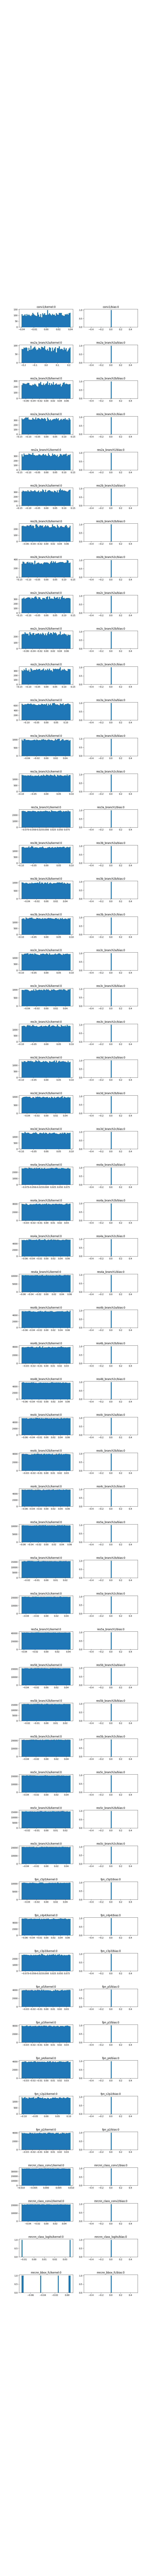

conv1/kernel:0 (7, 12, 64)
conv1/bias:0 ()
res2a_branch2a/kernel:0 (1, 64, 64)
res2a_branch2a/bias:0 ()
res2a_branch2b/kernel:0 (3, 64, 64)
res2a_branch2b/bias:0 ()
res2a_branch2c/kernel:0 (1, 64, 256)
res2a_branch2c/bias:0 ()
res2a_branch1/kernel:0 (1, 64, 256)
res2a_branch1/bias:0 ()
res2b_branch2a/kernel:0 (1, 256, 64)
res2b_branch2a/bias:0 ()
res2b_branch2b/kernel:0 (3, 64, 64)
res2b_branch2b/bias:0 ()
res2b_branch2c/kernel:0 (1, 64, 256)
res2b_branch2c/bias:0 ()
res2c_branch2a/kernel:0 (1, 256, 64)
res2c_branch2a/bias:0 ()
res2c_branch2b/kernel:0 (3, 64, 64)
res2c_branch2b/bias:0 ()
res2c_branch2c/kernel:0 (1, 64, 256)
res2c_branch2c/bias:0 ()
res3a_branch2a/kernel:0 (1, 256, 128)
res3a_branch2a/bias:0 ()
res3a_branch2b/kernel:0 (3, 128, 128)
res3a_branch2b/bias:0 ()
res3a_branch2c/kernel:0 (1, 128, 512)
res3a_branch2c/bias:0 ()
res3a_branch1/kernel:0 (1, 256, 512)
res3a_branch1/bias:0 ()
res3b_branch2a/kernel:0 (1, 512, 128)
res3b_branch2a/bias:0 ()
res3b_branch2b/kernel:0 (3, 12

In [28]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = resid_model.model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
num_weights =0 
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        print(tensor.name, weight[w].shape)
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)
        num_weights += len(weight[w].flatten())

In [46]:
print("Weights in entire model:", num_weights)

Weights in entire model: 32814460


In [29]:
print("Weights in entire model:", num_weights)

Weights in entire model: 18396480


In [39]:
weight[w], w

(0.0, 1)

In [29]:
modellib.log("model.anchors", resid_model.model.anchors)

model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64


In [30]:
activations = resid_model.model.run_graph(image, [
    ("input_image",        resid_model.model.keras_model.get_layer("input_image").output),
    ("input_image_shape",  resid_model.model.keras_model.get_layer("input_image_shape").output),
    ("input_anchors",      resid_model.model.keras_model.get_layer("input_anchors").output),
    ("fpn_c5p5",           resid_model.model.keras_model.get_layer("fpn_c5p5").output), 
    ("fpn_c3p3",           resid_model.model.keras_model.get_layer("fpn_c3p3").output),
    ("fpn_c2p2",           resid_model.model.keras_model.get_layer("fpn_c2p2").output),
    ("res5c_out",          resid_model.model.keras_model.get_layer("res5c_out").output)
])

input_image              shape: (1, 128, 128, 12)     min:   -5.44641  max:    6.55121  float32
input_image_shape        shape: (1, 3)                min:   12.00000  max:  128.00000  float32
input_anchors            shape: (1, 340, 4)           min:    0.00000  max:    1.00000  float32
fpn_c5p5                 shape: (1, 4, 4, 256)        min:   -1.61836  max:    2.15246  float32
fpn_c3p3                 shape: (1, 16, 16, 256)      min:   -1.47973  max:    1.19854  float32
fpn_c2p2                 shape: (1, 32, 32, 256)      min:   -1.40416  max:    1.71956  float32
res5c_out                shape: (1, 4, 4, 2048)       min:    0.00000  max:    2.40863  float32


In [31]:
modellib.log("model.anchors", resid_model.model.anchors)

model.anchors            shape: (340, 4)              min:    0.00000  max:  128.00000  float64


Input Image Activations


<IPython.core.display.Javascript object>


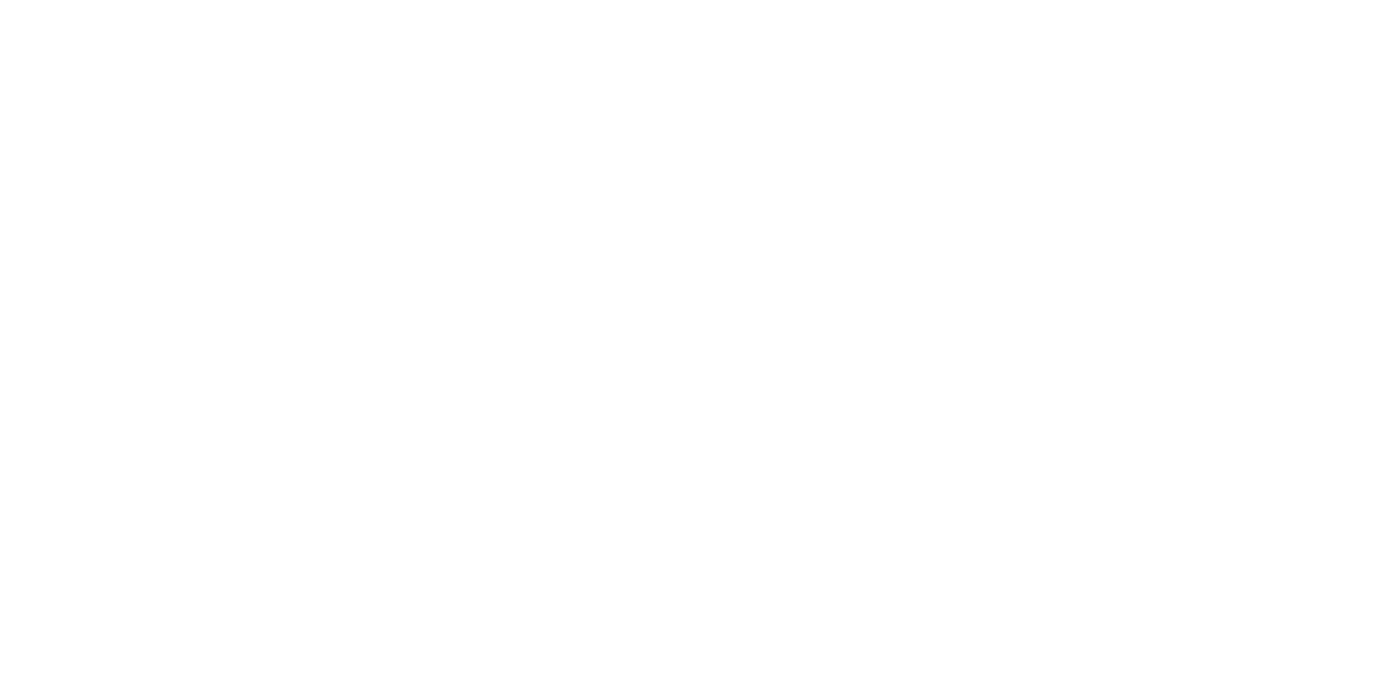

5, 95 percentile are:  -1.189744234085083 1.1936906576156616


In [32]:
print("Input Image Activations")
display_images(np.transpose(activations["input_image"][0], [2, 0, 1]), cols=6,
               cmap='bwr', same_color=True,color_range=(-2, 2))

FPN 5 Activations


<IPython.core.display.Javascript object>


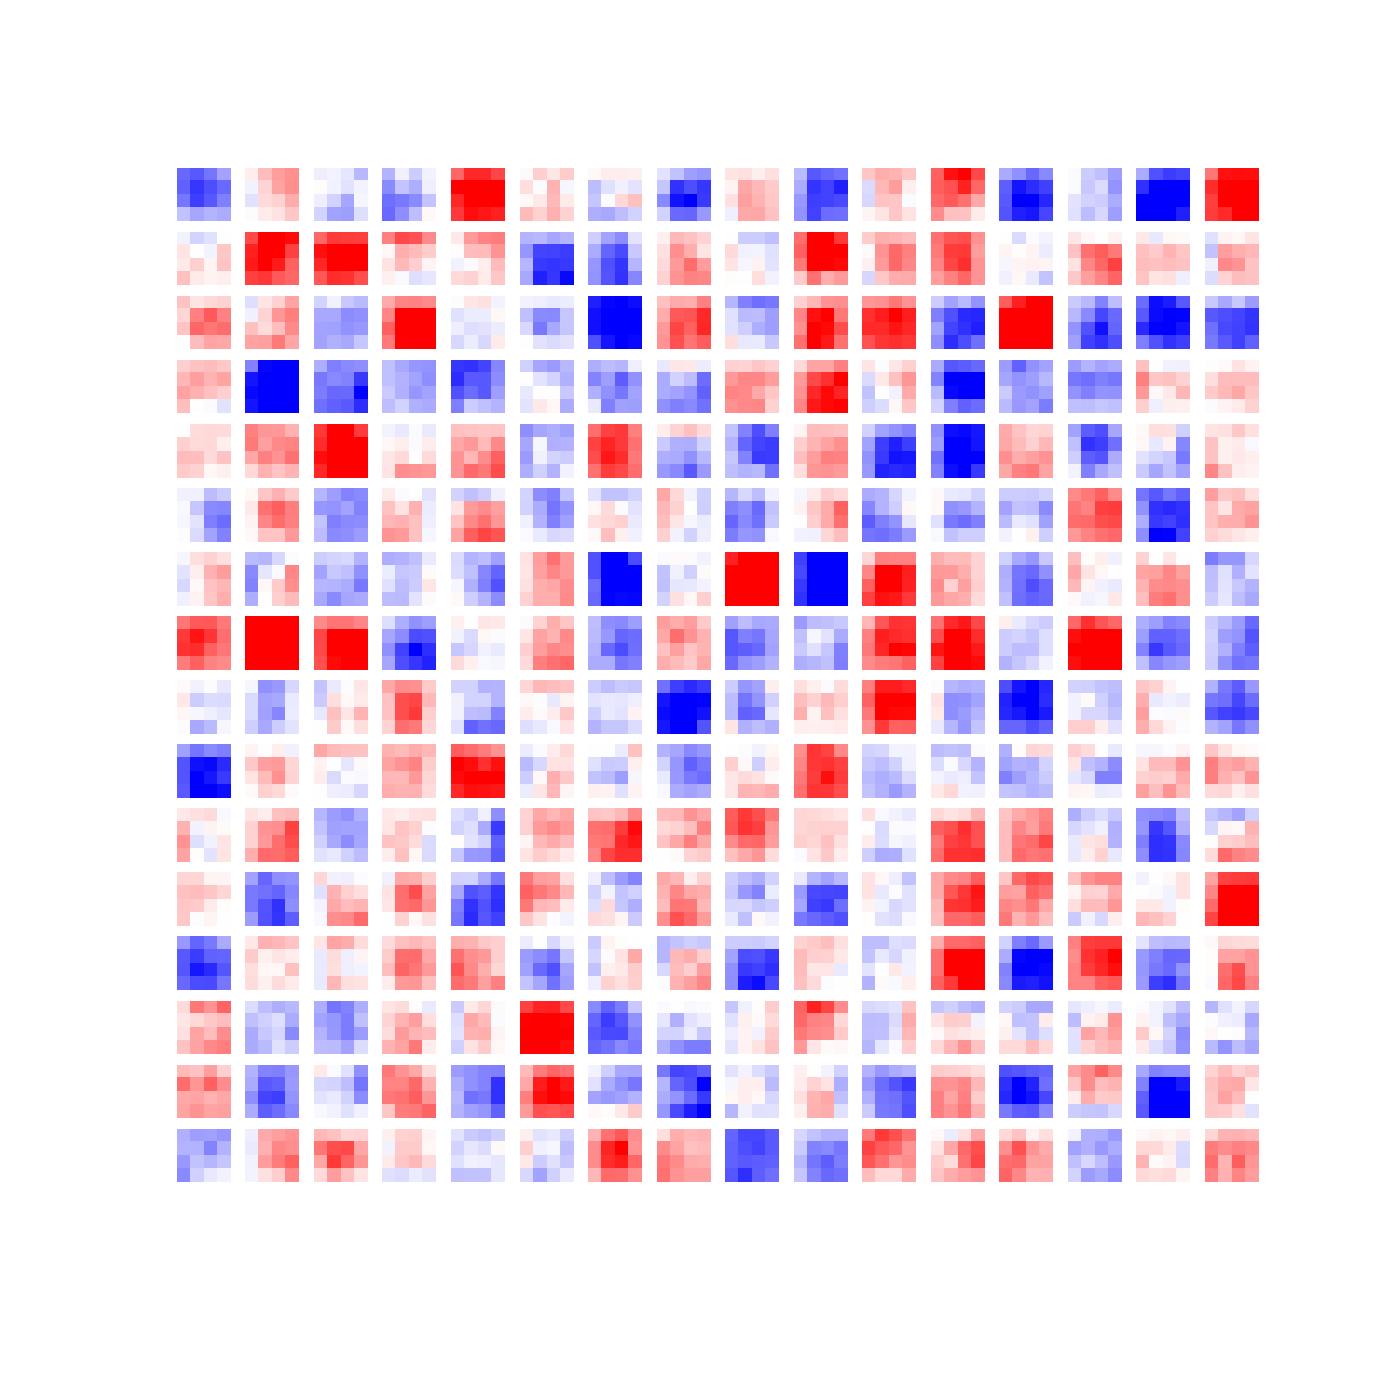

5, 95 percentile are:  -0.799981027841568 0.9228363037109375


In [33]:
print("FPN 5 Activations")
display_images(np.transpose(activations["fpn_c5p5"][0], [2, 0, 1]), cols=16,
               cmap='bwr', same_color=True,color_range=(-1, 1))

FPN 3 Activations


<IPython.core.display.Javascript object>


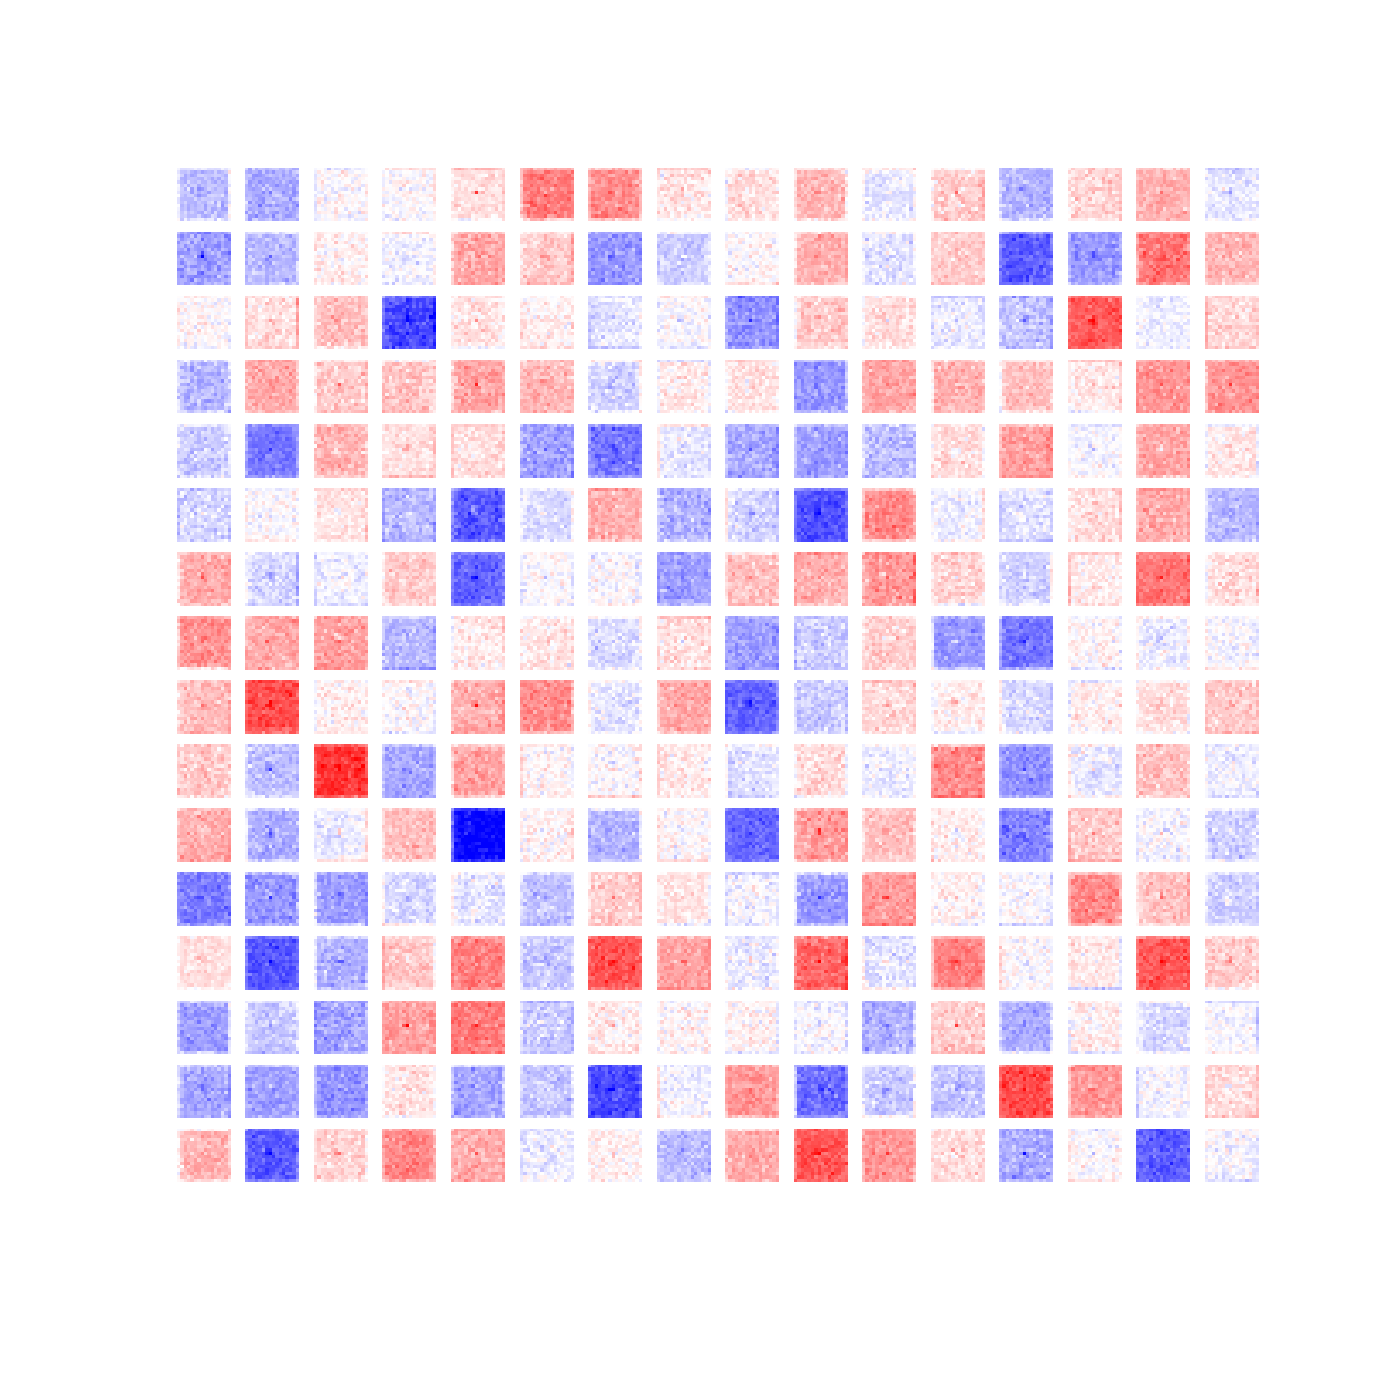

5, 95 percentile are:  -0.5405333787202835 0.5058758705854416


In [34]:
print("FPN 3 Activations")
display_images(np.transpose(activations["fpn_c3p3"][0], [2, 0, 1]), cols=16,
               cmap='bwr', same_color=True,color_range=(-1, 1))

FPN 2 Activations


<IPython.core.display.Javascript object>


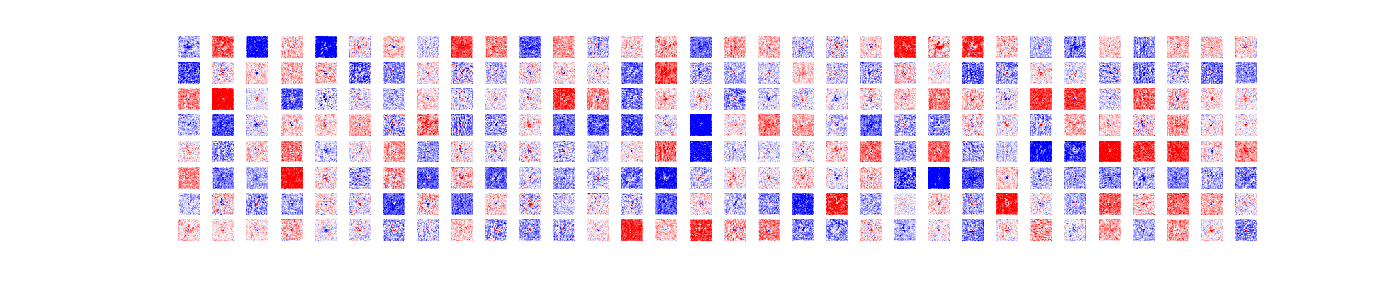

5, 95 percentile are:  -0.8184721469879149 0.7846187084913231


In [82]:
print("FPN 2 Activations")
display_images(np.transpose(activations["fpn_c2p2"][0], [2, 0, 1]), cols=32,
               cmap='bwr', same_color=True,color_range=(-1, 1))

Input Image Activations


<IPython.core.display.Javascript object>


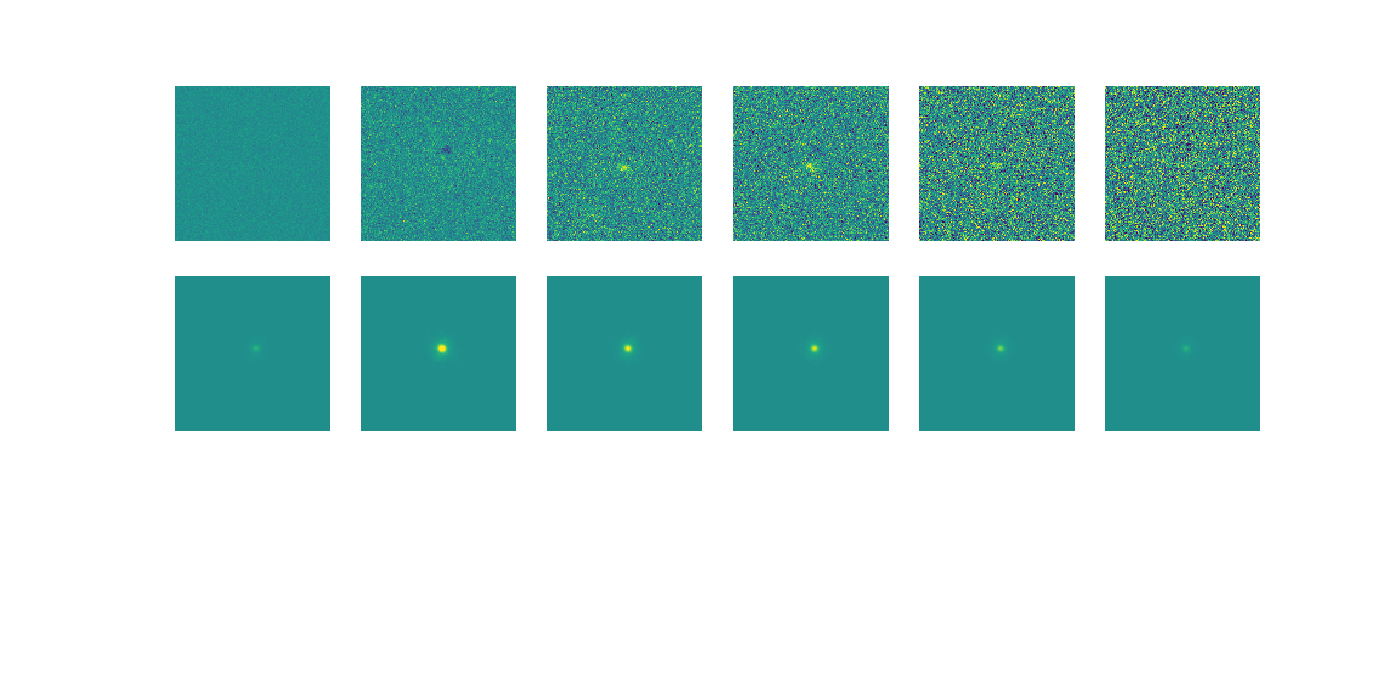

5, 95 percentile are:  -1.6633363962173462 1.6827346086502075
Res2 Activations


<IPython.core.display.Javascript object>


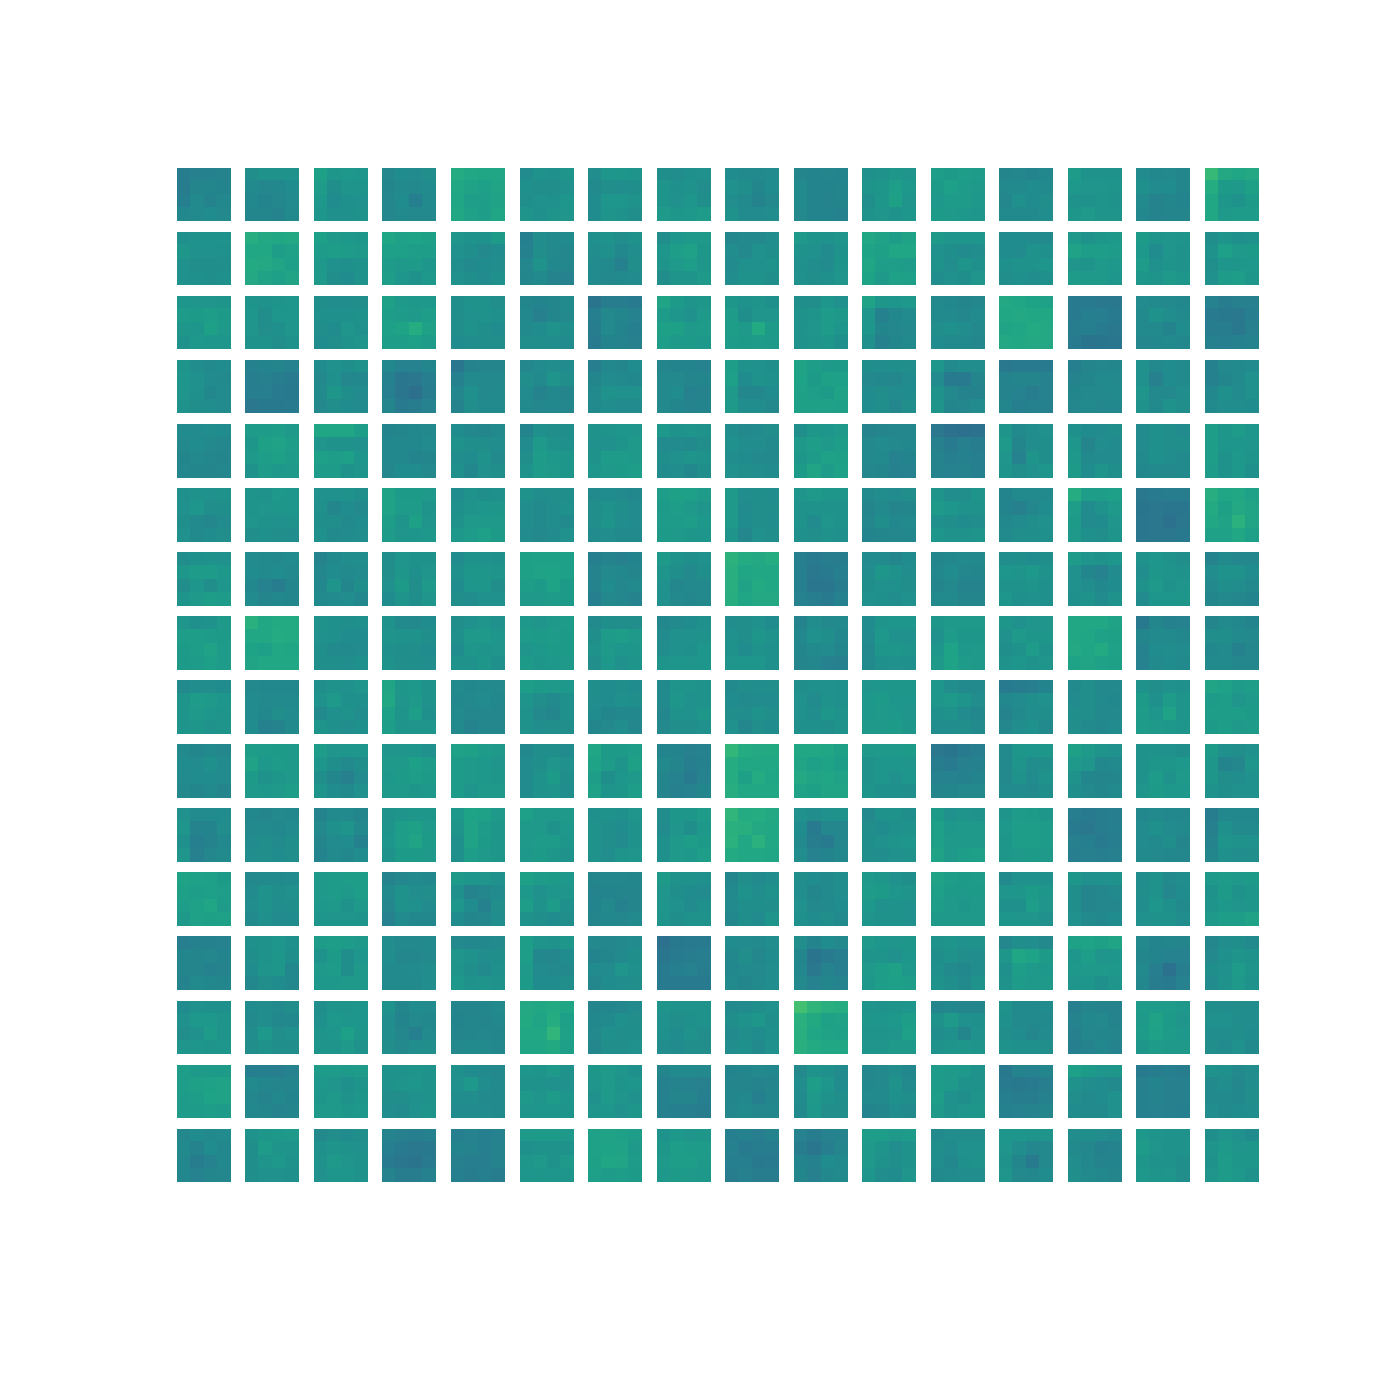

5, 95 percentile are:  -0.5486522018909454 0.6197114586830139
Res3 Activations


<IPython.core.display.Javascript object>


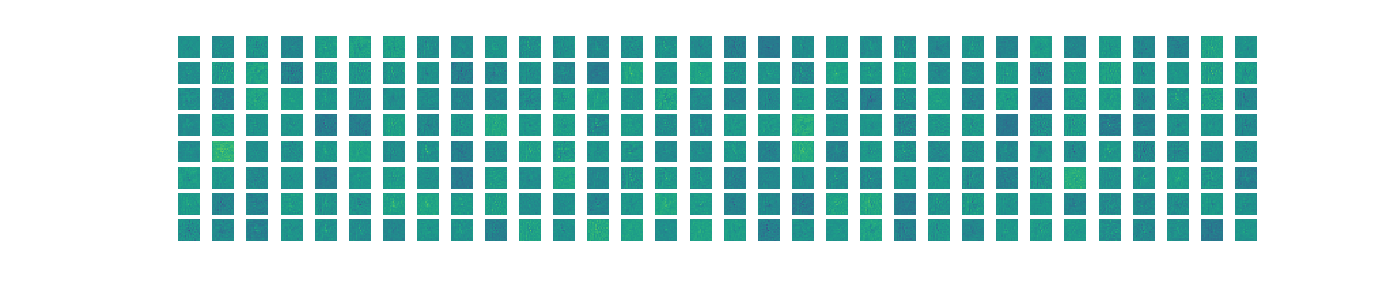

5, 95 percentile are:  -0.6506544649600983 0.7548584938049316
Res4 Activations


<IPython.core.display.Javascript object>


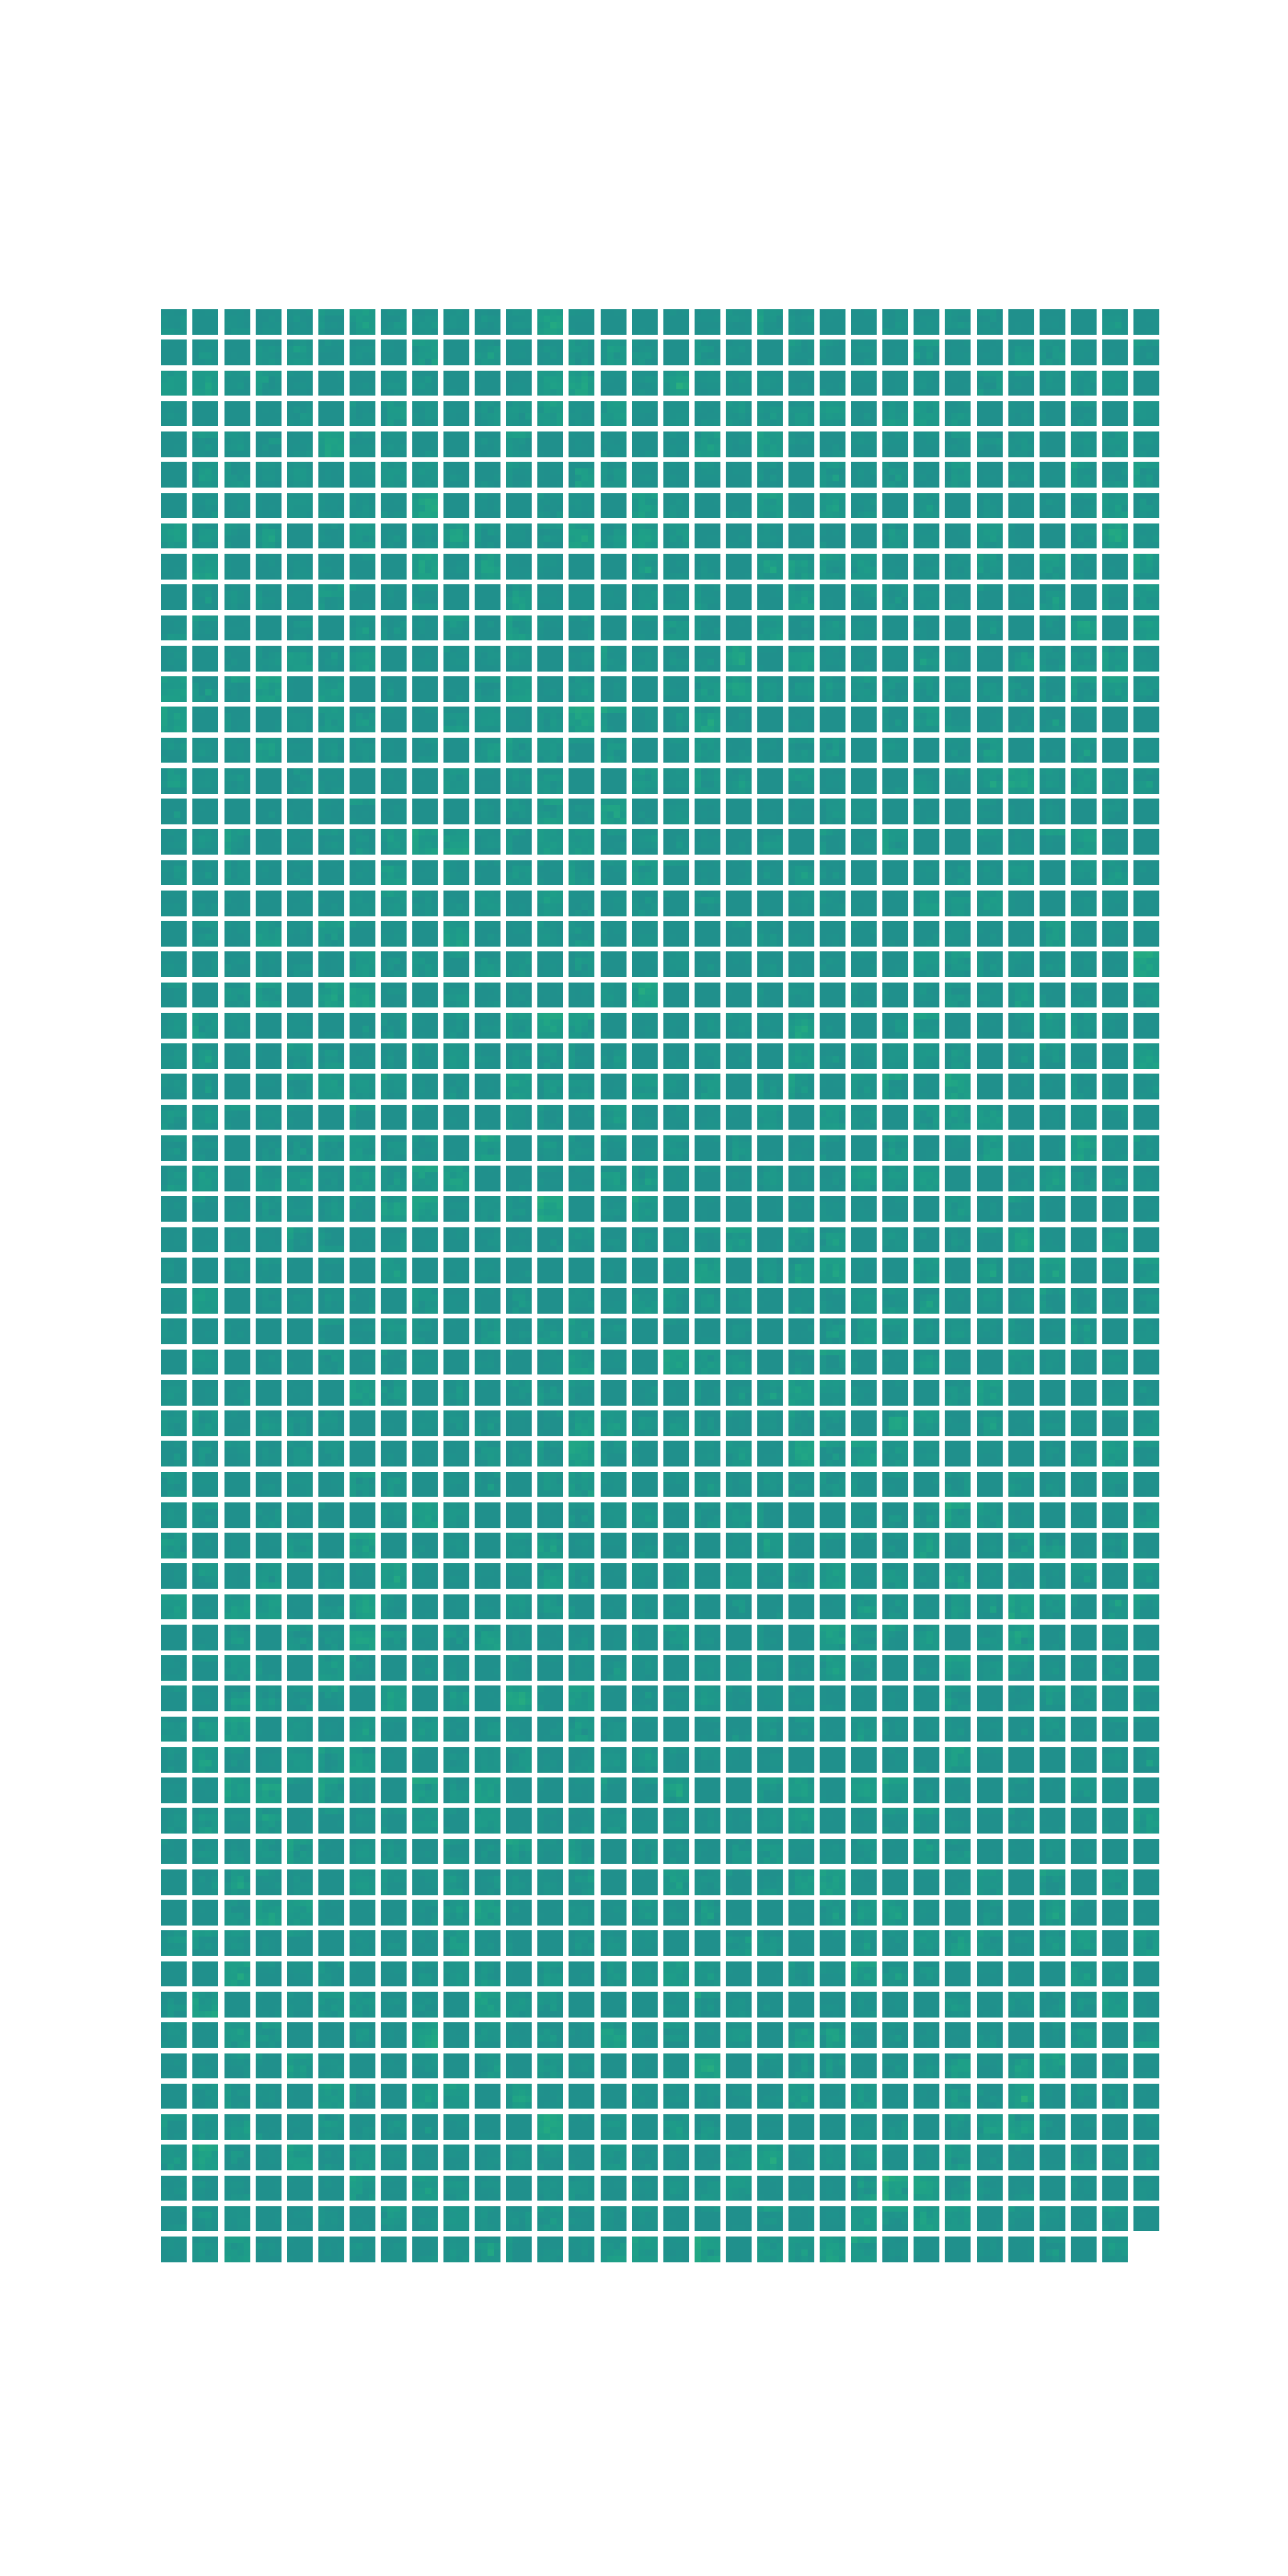

5, 95 percentile are:  0.0 0.43651634156703945


In [16]:

print("FPN 33 Activations")
display_images(np.transpose(activations["fpn_c3p3"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-4, 4))
print("Res5 Activations")
display_images(np.transpose(activations["res5c_out"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-4, 4))

In [53]:
detections, _, _, _, _, _ =\
            resid_model.model.keras_model.predict([images, image_shape, anchors],
                                     verbose=1)

1/1 [==============================] - 0s 41ms/step


In [61]:
resid_model.model.config.IMAGE_SHAPE

array([128, 128,  12])

In [59]:
detections[0, 0, :4]*128, r['rois']



(array([62.447872, 59.739513, 68.70067 , 65.99231 ], dtype=float32),
 array([[62, 59, 68, 65]], dtype=int32))

In [ ]:
activations = model.run_graph(image, [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("input_image_shape",  model.keras_model.get_layer("input_image_shape").output),
    ("input_anchors",      model.keras_model.get_layer("input_anchors").output),
    ("fpn_c5p5",          model.keras_model.get_layer("fpn_c5p5").output),  # for resnet100
    ("res5c_out",          model.keras_model.get_layer("res5c_out").output)
])


print("Input Image Activations")
display_images(np.transpose(activations["input_image"][0], [2, 0, 1]), cols=6, same_color=True,color_range=(-0.4, 0.4))
print("Res2 Activations")
display_images(np.transpose(activations["res2c_out"][0], [2, 0, 1]), cols=16, same_color=True,color_range=(-0.4, 0.4))
print("Res3 Activations")
display_images(np.transpose(activations["res3d_out"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-0.4, 0.4))
print("Res4 Activations")
display_images(np.transpose(activations["res4w_out"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(-0.4, 0.4))


In [ ]:
activations = model.run_graph(image, [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3d_out",          model.keras_model.get_layer("res3d_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("res5c_out",          model.keras_model.get_layer("res5c_out").output)
])


print("Input Image Activations")
display_images(np.transpose(activations["input_image"][0], [2, 0, 1]), cols=6, same_color=True,color_range=(0, 0.4))
print("Res2 Activations")
display_images(np.transpose(activations["res2c_out"][0], [2, 0, 1]), cols=16, same_color=True,color_range=(0, 0.4))
print("Res3 Activations")
display_images(np.transpose(activations["res3d_out"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(0, 0.4))
print("Res4 Activations")
display_images(np.transpose(activations["res4w_out"][0], [2, 0, 1]), cols=32, same_color=True,color_range=(0, 0.4))
print("Res5 Activations")
display_images(np.transpose(activations["res5c_out"][0], [2, 0, 1]), cols=64, same_color=True,color_r

In [35]:
ax=get_ax(rows=1, cols=5)
for l in range(levels):

array([32, 32])

In [26]:
backbone_shapes = modellib.compute_backbone_shapes(resid_model.config, image_shape[0])
num_levels = len(backbone_shapes)
anchors_per_cell = len(resid_model.config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", resid_model.config.RPN_ANCHOR_SCALES)
print("ratios: ", resid_model.config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // inference_config.RPN_ANCHOR_STRIDE**2)
fig, ax = plt.subplots(1, figsize=(4, 4))
rgb = scarlet.display.img_to_rgb(np.transpose(image[:, :, 1:4], axes=(2, 0, 1)))

ax.imshow(rgb)
levels = len(backbone_shapes)
colors = visualize.random_colors(levels)
for level in range(levels):
    
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / inference_config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / inference_config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

ax=get_ax(rows=1, cols=5)
for l in range(levels):
    anchors_l = utils.generate_anchors_no_spill(inference_config.RPN_ANCHOR_SCALES[l], [1], backbone_shapes[l],
                                              inference_config.BACKBONE_STRIDES[l], 
                                              inference_config.RPN_ANCHOR_STRIDE)
    visualize.display_instances(image, anchors_l, np.ones(len(anchors_l), dtype=int), 
                                class_names, None, ax=ax[l], colors=[colors[l]]*len(anchors_l))

array([128, 128], dtype=int32)

In [30]:
image_shape[0,:2]

array([128, 128], dtype=int32)

In [29]:
anchors_denorm

array([[[ 0.        ,  0.        , -0.00768802, -0.00768802],
        [ 0.        ,  0.000248  , -0.00768802, -0.00744001],
        [ 0.        ,  0.000496  , -0.00768802, -0.00719201],
        ...,
        [ 0.        ,  0.00396801, -0.00396801,  0.        ],
        [ 0.00396801,  0.        ,  0.        , -0.00396801],
        [ 0.00396801,  0.00396801,  0.        ,  0.        ]]],
      dtype=float32)

<IPython.core.display.Javascript object>


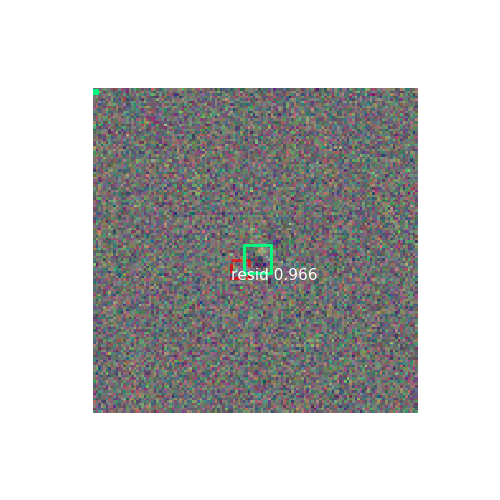

In [2]:
DATA_PATH = '/scratch/users/sowmyak/data'
import rd_btk_utils
catalog_name = os.path.join(DATA_PATH, 'OneDegSq.fits')
param = btk.config.Simulation_params(
    catalog_name, max_number=2, stamp_size=25.6,
    batch_size=1, seed=199)
wld_catalog_name = None
if wld_catalog_name:
    param.wld_catalog_name = wld_catalog_name
print("setting seed", param.seed)
np.random.seed(param.seed)
# Load input catalog
selection_function = None
catalog = btk.get_input_catalog.load_catalog(
    param, selection_function=selection_function)
# Generate catalogs of blended objects
sampling_function = btk_utils.resid_general_sampling_function
blend_generator = btk.create_blend_generator.generate(
    param, catalog, sampling_function)
# Generates observing conditions
observing_generator = btk.create_observing_generator.generate(
    param, btk_utils.resid_obs_conditions)
# Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(
    param, blend_generator, observing_generator)

model_file_name = 'resid_btk_square_group_3_20190213T1020/mask_rcnn_resid_btk_square_group_3__0263.h5'
resid_meas = rd_btk_utils.RD_group_measure_params(model_file_name=model_file_name)



setting seed 199
wld catalog provided: /scratch/users/sowmyak/data/train_group_min_snr_01.fits
setting seed 199
Setting scarlet_resid_paramsa as meas_params
Loaded 4000 blends
detection minimum confidence score: 0.96
Loading weights from  /scratch/users/sowmyak/resid/logs/resid_btk_square_group_3_20190213T1020/mask_rcnn_resid_btk_square_group_3__0263.h5
Re-starting from epoch 263


In [33]:
inference_config = resid_meas.resid_model.config

In [38]:
inference_config.BACKBONE

'resnet101'

In [35]:
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.96
DETECTION_NMS_THRESHOLD        0.2
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128  12]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               10
MEAN_PIXEL

<IPython.core.display.Javascript object>


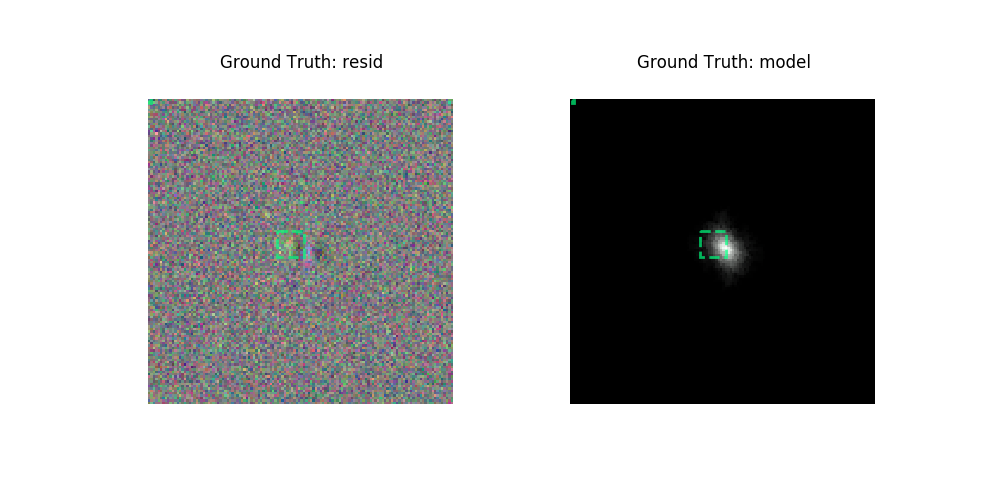

Input Image              shape: (128, 128, 12)        min: -3541.98126  max: 4951.09439  float64


<IPython.core.display.Javascript object>


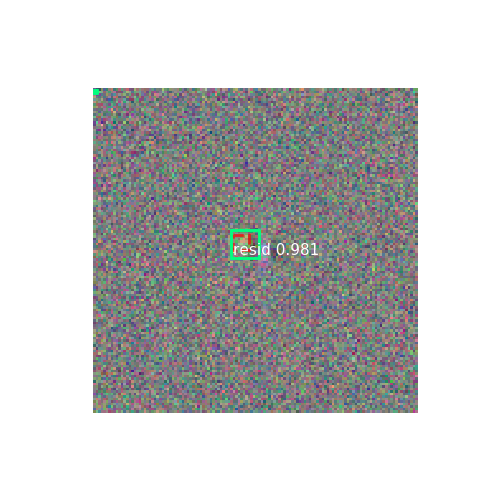

In [28]:
data = next(draw_blend_generator)
resid_output = resid_meas.get_deblended_images(data, 0)
resid_image = resid_output['resid_image']
model_image = resid_output['deblend_image']
image = np.dstack([resid_image, model_image])
gt_bbox = resid_output['target_bbox']
gt_class_id = resid_output['target_class']
true_cent = resid_meas.true_cent
det_cent = resid_meas.det_cent
r = resid_output['prediction']
it_det_cent = resid_output['peaks']

ax = get_ax(cols=2)
class_names= ['background', 'resid']
log("Input Image", image)
visualize.display_instances(image, gt_bbox, gt_class_id, 
                            class_names, None, ax=ax[0],
                            title="Ground Truth: resid", colors=['#00FF7F']*2)

#ax = get_ax(1)
flip = np.concatenate((image[:,:,6:12], image[:,:,0:6]), axis=2)
visualize.display_instances(flip, gt_bbox, gt_class_id, 
                            class_names, None, ax=ax[1],
                            title="Ground Truth: model", colors=['#00FF7F']*2)

ax = get_ax(rows=1, cols=1)
visualize.display_instances(image, r['rois'], r['class_ids'], 
                                class_names, r['scores'], ax=ax,
                                title="Residual", limits=(34, 94))
visualize.draw_boxes(image, boxes=gt_bbox, refined_boxes=gt_bbox, ax=ax, colors=['#00FF7F']*len(gt_bbox))


In [29]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
model =resid_meas.resid_model.model
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )




target_rpn_match         shape: (1364,)               min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 3)              min:   -6.93147  max:    1.59227  float64
positive_anchors         shape: (2, 4)                min:    0.00000  max:   64.00000  float64
negative_anchors         shape: (254, 4)              min:    0.00000  max:  128.00000  float64
neutral anchors          shape: (1108, 4)             min:    0.00000  max:  128.00000  float64
refined_anchors          shape: (2, 4)                min:    0.00000  max:   66.00000  float32


<IPython.core.display.Javascript object>


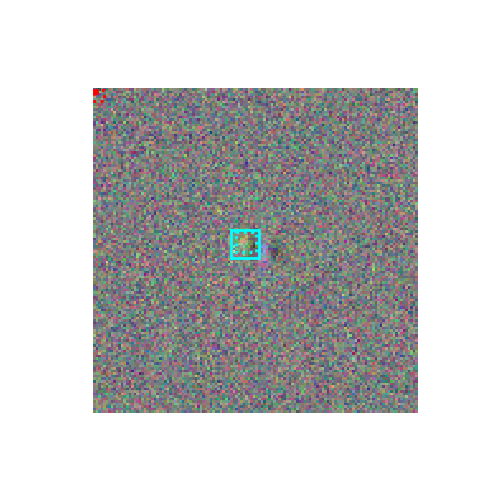

In [30]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [39]:
images  = [image]
image_shape = np.array([images[0].shape]*inference_config.BATCH_SIZE)

In [43]:
modellib.compute_backbone_shapes(inference_config, image_shape[0])

array([[32, 32],
       [16, 16],
       [ 8,  8],
       [ 4,  4],
       [ 2,  2]])

In [44]:
anchors = model.get_anchors(image_shape[0][:2])

In [54]:
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")
    
nms_node.values()

AttributeError: 'Tensor' object has no attribute 'values'

In [55]:
rpn['pre_nms_anchors']

array([[[0.        , 0.        , 0.02362205, 0.02362205],
        [0.28346458, 0.22047244, 0.30708662, 0.24409449],
        [0.3464567 , 0.        , 0.37007874, 0.02362205],
        ...,
        [0.2519685 , 0.72440946, 0.27559054, 0.7480315 ],
        [0.2519685 , 0.7559055 , 0.27559054, 0.77952754],
        [0.2519685 , 0.78740156, 0.27559054, 0.8110236 ]]], dtype=float32)

In [57]:
np.reshape(inference_config.RPN_BBOX_STD_DEV, [1, 1, 3])

array([[[0.1, 0.1, 0.2]]])

In [61]:
a = model.run_graph([image], [
    ("rpn_bbox", model.keras_model.get_layer("rpn_bbox").output)])['rpn_bbox']

np.exp(a[:, 2])

rpn_bbox                 shape: (1, 1364, 3)          min: -271.30844  max:  954.64655  float32


array([[5.9124146e+16, 1.2109184e+29, 1.5843872e-22]], dtype=float32)

In [68]:
a

array([[[-155.83507 , -151.3522  , -271.30844 ],
        [ -27.672113,  -38.541126, -128.70428 ],
        [  38.618416,   66.96635 ,  -50.196674],
        ...,
        [ 108.473946,  -52.10665 ,   55.020206],
        [ -28.270052,  146.8599  ,   44.678844],
        [ -67.28106 ,   16.028128,   65.50561 ]]], dtype=float32)

In [70]:
a[:, :,2]

array([[-271.30844 , -128.70428 ,  -50.196674, ...,   55.020206,
          44.678844,   65.50561 ]], dtype=float32)

In [31]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 1364, 2)          min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 500, 4)           min:    0.00000  max:    1.00000  float32
refined_anchors          shape: (1, 500, 4)           min:        nan  max:        nan  float32
refined_anchors_clipped  shape: (1, 500, 4)           min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (100,)                min:    0.00000  max:  149.00000  int32
proposals                shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32


/share/software/user/open/py-keras/2.1.5_py36/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/share/software/user/open/py-keras/2.1.5_py36/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [20]:
rpn['rpn_class'][:,:,1].flatten()

array([1.0000000e+00, 2.2508966e-38, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

<IPython.core.display.Javascript object>


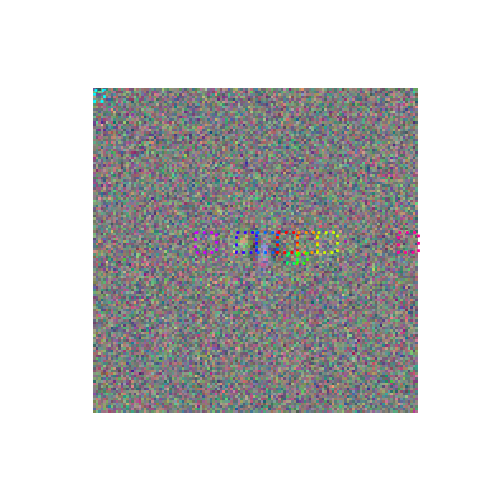

In [32]:
# Show top anchors by score (before refinement)
limit = 10
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

/home/users/sowmyak/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


setting seed 199
Setting scarlet_resid_paramsa as meas_params
Loaded 4000 blends
detection minimum confidence score: 0.965
Loading weights from  /scratch/users/sowmyak/resid/logs/resid_btk_square_group_3_20190213T1020/mask_rcnn_resid_btk_square_group_3__0263.h5
Re-starting from epoch 263


In [2]:
DATA_PATH = '/scratch/users/sowmyak/data'
catalog_name = os.path.join(DATA_PATH, 'OneDegSq.fits')
param = btk.config.Simulation_params(
    catalog_name, max_number=2, stamp_size=25.6,
    batch_size=1, seed=199)
wld_catalog_name = None
if wld_catalog_name:
    param.wld_catalog_name = wld_catalog_name
print("setting seed", param.seed)
np.random.seed(param.seed)
# Load input catalog
selection_function = None
catalog = btk.get_input_catalog.load_catalog(
    param, selection_function=selection_function)
# Generate catalogs of blended objects
sampling_function = btk_utils.resid_general_sampling_function
blend_generator = btk.create_blend_generator.generate(
    param, catalog, sampling_function)
# Generates observing conditions
observing_generator = btk.create_observing_generator.generate(
    param, btk_utils.resid_obs_conditions)
# Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(
    param, blend_generator, observing_generator)

setting seed 199
